In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
raw_data = pd.read_csv('generated_values2years.csv')
df = raw_data.copy()

In [3]:
df.columns

Index(['fin_record_key', 'fin_debit_credit_ind', 'fin_company_id',
       'fin_trans_dt', 'fin_source_amt', 'fin_acct_num'],
      dtype='object')

In [4]:
df.drop(['fin_record_key','fin_debit_credit_ind','fin_acct_num','fin_company_id'],axis=1,inplace=True)

In [5]:
df.head()

,fin_trans_dt,fin_source_amt
0,2024-06-21,179.73
1,2024-11-25,450.87
2,2024-09-05,238.07
3,2024-06-30,210.59
4,2024-09-10,283.52


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   fin_trans_dt    2000 non-null   object 
 1   fin_source_amt  2000 non-null   float64
dtypes: float64(1), object(1)
memory usage: 31.4+ KB


In [7]:
df = df.groupby(df['fin_trans_dt']).agg({'fin_source_amt': 'sum'}).rename(columns={'fin_source_amt': 'Sum_amt'}).reset_index()

In [8]:
df['fin_trans_dt'] = pd.to_datetime(df['fin_trans_dt'])

In [9]:
df = df.sort_values('fin_trans_dt')

In [10]:
df.set_index('fin_trans_dt',inplace=True)

In [11]:
# Date features
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['year'] = df.index.year

In [12]:
# Lag features (e.g., lag 1, lag 7)
df['lag_1'] = df['Sum_amt'].shift(1)
df['lag_7'] = df['Sum_amt'].shift(7)

In [13]:
# Rolling statistics
df['rolling_mean_7'] = df['Sum_amt'].rolling(window=7).mean()
df['rolling_mean_30'] = df['Sum_amt'].rolling(window=30).mean()

In [14]:
# Fill missing values with 0
df = df.fillna(0)

In [15]:
df.isna().sum()

Sum_amt            0
day_of_week        0
month              0
quarter            0
year               0
lag_1              0
lag_7              0
rolling_mean_7     0
rolling_mean_30    0
dtype: int64

In [19]:
#Splitting data
df_train,df_test = df.loc[:"2025-06-30"],df.loc["2025-07-01":]

In [20]:
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA

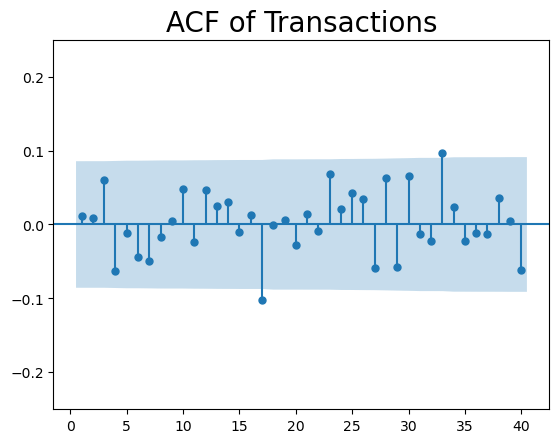

In [21]:
sgt.plot_acf(df_train['Sum_amt'],zero=False,lags=40)
plt.title('ACF of Transactions',size=20)
plt.ylim(-0.25,0.25)
plt.show()

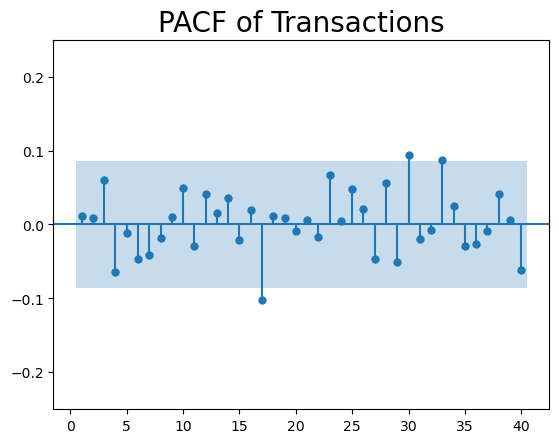

In [22]:
sgt.plot_pacf(df_train['Sum_amt'],zero=False,lags=40,method='ols')
plt.title('PACF of Transactions',size=20)
plt.ylim(-0.25,0.25)
plt.show()

In [23]:
sts.adfuller(df_train['Sum_amt'])

(-22.589270062267403,
 0.0,
 0,
 523,
 {'1%': -3.4429153652063986,
  '5%': -2.8670821452874007,
  '10%': -2.5697217608736187},
 7622.989218077338)

In [24]:
#ARIMAX(1,1,1)

#set start and end date

start_date = '2025-07-01'
end_date = '2025-12-31'

model = ARIMA(df_train['Sum_amt'],order=(34,0,34),exog=df_train[['day_of_week', 'month', 'quarter', 'lag_1', 'lag_7',
       'rolling_mean_7', 'rolling_mean_30']])
results = model.fit()
print(results.summary())

df_pred = results.predict(start=len(df_train),end=len(df_train)+len(df_test)-1,exog=df_test[['day_of_week', 'month', 'quarter', 'lag_1', 'lag_7', 'rolling_mean_7', 'rolling_mean_30']])




D:\Users\sharesh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Users\sharesh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Users\sharesh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Users\sharesh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starti

                               SARIMAX Results                                
Dep. Variable:                Sum_amt   No. Observations:                  524
Model:               ARIMA(34, 0, 34)   Log Likelihood               -3828.292
Date:                Mon, 18 Mar 2024   AIC                           7810.584
Time:                        15:57:14   BIC                           8138.719
Sample:                             0   HQIC                          7939.085
                                - 524                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             361.1455     81.064      4.455      0.000     202.264     520.027
day_of_week        -7.1462      9.820     -0.728      0.467     -26.394      12.101
month               2.8699      

D:\Users\sharesh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\Users\sharesh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [25]:
predictions = pd.DataFrame(df_pred.values,index=df_test.index,columns=['Pred_Sum_amt'])

In [26]:
predictions

,Pred_Sum_amt
fin_trans_dt,
2025-07-01,562.155642
2025-07-02,682.986460
2025-07-03,711.956661
2025-07-05,766.012087
2025-07-06,814.033050
...,...
2025-12-27,1045.840096
2025-12-28,507.482674
2025-12-29,1098.429463


In [27]:
cmp = pd.concat([df_test['Sum_amt'],predictions],axis=1)

In [28]:
cmp.head()

,Sum_amt,Pred_Sum_amt
fin_trans_dt,,
2025-07-01,659.67,562.155642
2025-07-02,646.76,682.986460
2025-07-03,714.10,711.956661
2025-07-05,796.77,766.012087
2025-07-06,958.23,814.033050


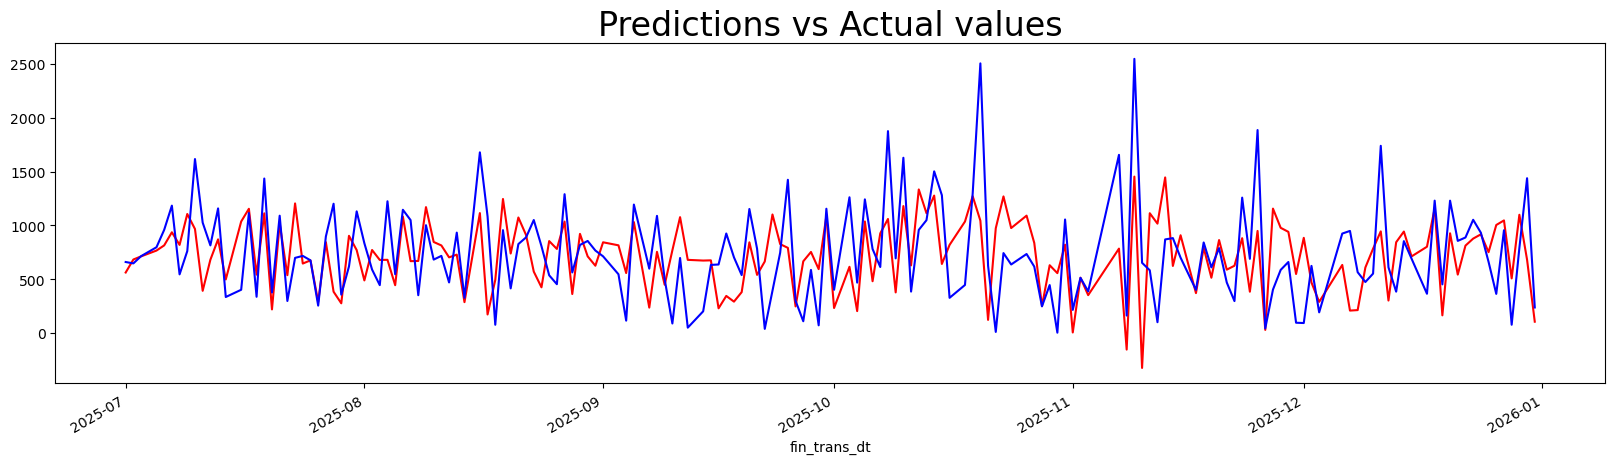

In [29]:
cmp['Pred_Sum_amt'].plot(figsize=(20,5),color="red")
cmp['Sum_amt'].plot(color="blue")
plt.title("Predictions vs Actual values",size=24)
plt.show()

In [30]:
print('RMSE:',np.sqrt(mean_squared_error(cmp['Sum_amt'],cmp['Pred_Sum_amt'])))

RMSE: 416.47576255367454


In [37]:
start_date = "2026-01-01"
end_date = "2026-06-30"

D:\Users\sharesh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Users\sharesh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Users\sharesh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Users\sharesh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starti

                               SARIMAX Results                                
Dep. Variable:                Sum_amt   No. Observations:                  692
Model:               ARIMA(34, 0, 34)   Log Likelihood               -5057.473
Date:                Mon, 18 Mar 2024   AIC                          10268.945
Time:                        16:05:49   BIC                          10618.493
Sample:                             0   HQIC                         10404.138
                                - 692                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             289.4029     70.792      4.088      0.000     150.652     428.153
day_of_week        -2.4608      7.467     -0.330      0.742     -17.096      12.175
month              -2.7771     1

D:\Users\sharesh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\Users\sharesh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


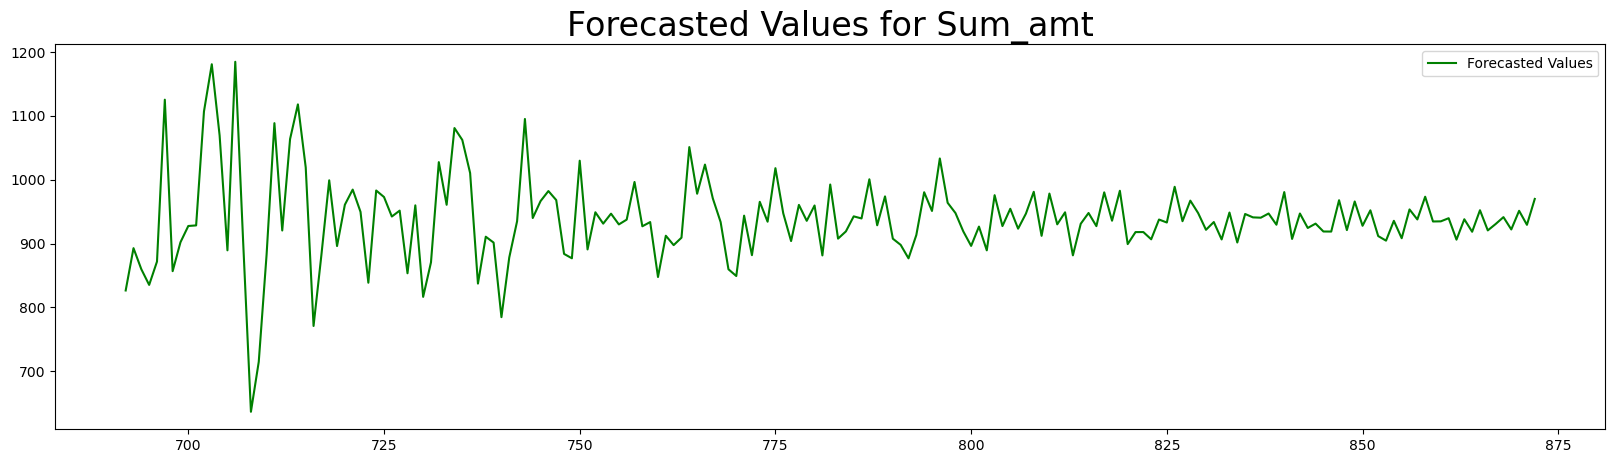

In [38]:
# # Calculate lag1 and lag7 values
# last_date = df.index[-1]
# lag1_value = df.loc[last_date, 'Sum_amt']
# lag7_value = df.loc[last_date - pd.DateOffset(days=7), 'Sum_amt']

# # Calculate rolling_mean_7 and rolling_mean_30 values
# rolling_mean_7_value = df['Sum_amt'].rolling(window=7).mean().iloc[-1]
# rolling_mean_30_value = df['Sum_amt'].rolling(window=30).mean().iloc[-1]

# Generate a date range for the forecast period
forecast_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Create a DataFrame with the forecast dates
df_forecast = pd.DataFrame(index=forecast_dates,columns=['day_of_week', 'month', 'quarter', 'year', 'lag_1', 'lag_7',
       'rolling_mean_7', 'rolling_mean_30'])

# Add the date features to the forecast DataFrame
df_forecast['day_of_week'] = df_forecast.index.dayofweek
df_forecast['month'] = df_forecast.index.month
df_forecast['quarter'] = df_forecast.index.quarter
df_forecast['year'] = df_forecast.index.year

# Calculate lag1 and lag7 values
last_date = df.index[-1]
lag1_value = df.loc[last_date, 'Sum_amt']
lag7_value = df.loc[last_date - pd.DateOffset(days=7), 'Sum_amt']

# Calculate rolling_mean_7 and rolling_mean_30 values
rolling_mean_7_value = df['Sum_amt'].rolling(window=7).mean().iloc[-1]
rolling_mean_30_value = df['Sum_amt'].rolling(window=30).mean().iloc[-1]

# Fill in NaN values in df_forecast with the calculated values
df_forecast['lag_1'] = df_forecast['lag_1'].fillna(lag1_value)
df_forecast['lag_7'] = df_forecast['lag_7'].fillna(lag7_value)
df_forecast['rolling_mean_7'] = df_forecast['rolling_mean_7'].fillna(rolling_mean_7_value)
df_forecast['rolling_mean_30'] = df_forecast['rolling_mean_30'].fillna(rolling_mean_30_value)

model_1 = ARIMA(df['Sum_amt'],order=(34,0,34),exog=df[['day_of_week', 'month', 'quarter',
                                                                 'lag_1', 'lag_7', 'rolling_mean_7', 'rolling_mean_30']])
results_1 = model_1.fit()
print(results_1.summary())

# Use the ARIMAX model to forecast
forecast_values = results_1.predict(start=len(df), end=len(df)+len(df_forecast)-1,exog=df_forecast[['day_of_week', 'month', 'quarter',
                                                                 'lag_1', 'lag_7', 'rolling_mean_7', 'rolling_mean_30']])

# Plot the forecasted values
plt.figure(figsize=(20, 5))
plt.plot(forecast_values, color="green", label="Forecasted Values")
plt.title("Forecasted Values for Sum_amt", size=24)
plt.legend()
plt.show()


In [39]:
forecasts = pd.DataFrame(forecast_values.values,index=df_forecast.index,columns=['Forecast_values'])

In [40]:
forecasts

,Forecast_values
2026-01-01,826.414824
2026-01-02,892.735555
2026-01-03,859.726209
2026-01-04,835.169609
2026-01-05,871.715503
...,...
2026-06-26,941.387138
2026-06-27,922.055068
2026-06-28,951.318617
2026-06-29,929.319221


<Axes: xlabel='fin_trans_dt'>

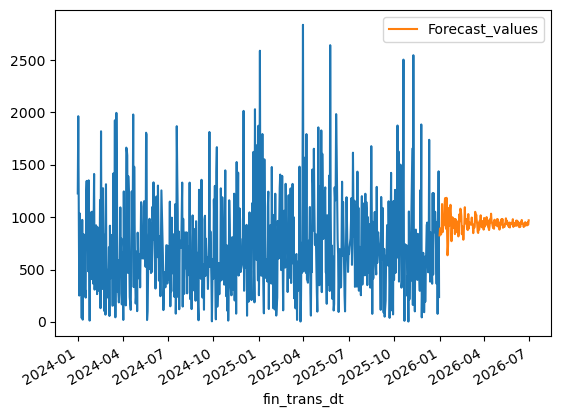

In [41]:
ax=df['Sum_amt'].plot()
forecasts.plot(ax=ax)

(20422.0, 20634.0)

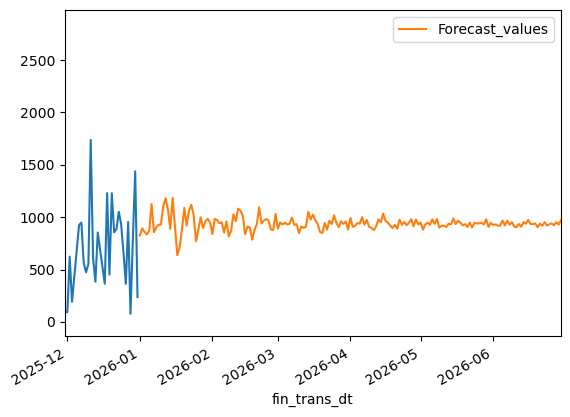

In [42]:
ax=df['Sum_amt'].plot()
forecasts.plot(ax=ax)
plt.xlim('2025-11-30','2026-06-30')

In [43]:
df_forecast.head(20)

,day_of_week,month,quarter,year,lag_1,lag_7,rolling_mean_7,rolling_mean_30
2026-01-01,3,1,1,2026,237.57,931.62,646.0,697.659
2026-01-02,4,1,1,2026,237.57,931.62,646.0,697.659
2026-01-03,5,1,1,2026,237.57,931.62,646.0,697.659
2026-01-04,6,1,1,2026,237.57,931.62,646.0,697.659
2026-01-05,0,1,1,2026,237.57,931.62,646.0,697.659
2026-01-06,1,1,1,2026,237.57,931.62,646.0,697.659
2026-01-07,2,1,1,2026,237.57,931.62,646.0,697.659
2026-01-08,3,1,1,2026,237.57,931.62,646.0,697.659
2026-01-09,4,1,1,2026,237.57,931.62,646.0,697.659
2026-01-10,5,1,1,2026,237.57,931.62,646.0,697.659
